# Part 3: Model Building

This notebook demonstrates how to build the **customer churn model** and an **interpretability model** to explain each prediction. In addition to making a prediction of whether a customer will churn, we will also be able to answer the question, "why are they expected to churn?"

The following work will look fairly standard to anyone having trained machine learning models using Python and Jupyter Notebooks. The CML platform provides a **fully capable Jupyter Notebook environment** that data scientists know and love.

If you haven't yet, run through the initialization steps in the README file and Part 1. In Part 1, the data is imported into the table you specified in Hive. All data accesses fetch from Hive if possible, otherwise pulls from local project storage.


## Load data

We again start by creating a `SparkSession` to fetch the data using Spark SQL, only this time we convert to a pandas `DataFrame` since we saw earlier that there are only 7k records in the dataset.


In [1]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.types import *

hive_database = os.environ['HIVE_DATABASE']
hive_table = os.environ['HIVE_TABLE']
hive_table_fq = hive_database + '.' + hive_table

# connect to Spark
spark = SparkSession\
    .builder\
    .appName("Telco Data Set")\
    .master("local[*]") \
    .getOrCreate()

# read data into a Spark DataFrame
if os.environ["STORAGE_MODE"] == "external":
    telco_data_raw = spark.sql("SELECT * FROM " + hive_table_fq)
else:
    path = "/home/cdsw/raw/WA_Fn-UseC_-Telco-Customer-Churn-.csv"
    schema = StructType(
                        [
                            StructField("customerID", StringType(), True),
                            StructField("gender", StringType(), True),
                            StructField("SeniorCitizen", StringType(), True),
                            StructField("Partner", StringType(), True),
                            StructField("Dependents", StringType(), True),
                            StructField("tenure", DoubleType(), True),
                            StructField("PhoneService", StringType(), True),
                            StructField("MultipleLines", StringType(), True),
                            StructField("InternetService", StringType(), True),
                            StructField("OnlineSecurity", StringType(), True),
                            StructField("OnlineBackup", StringType(), True),
                            StructField("DeviceProtection", StringType(), True),
                            StructField("TechSupport", StringType(), True),
                            StructField("StreamingTV", StringType(), True),
                            StructField("StreamingMovies", StringType(), True),
                            StructField("Contract", StringType(), True),
                            StructField("PaperlessBilling", StringType(), True),
                            StructField("PaymentMethod", StringType(), True),
                            StructField("MonthlyCharges", DoubleType(), True),
                            StructField("TotalCharges", DoubleType(), True),
                            StructField("Churn", StringType(), True),
                        ]
                    )
    telco_data_raw = spark.read.csv(path, header=True, sep=",", schema=schema, nullValue="NA")

telco_data_raw.printSchema()
df = telco_data_raw.toPandas()

Hive Session ID = 670b245e-d35b-4e07-9f8c-c417626dce4e


root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: double (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



## Basic feature engineering


Next we munge the data into appropriate types for later steps. 
In particular, we want to convert all the binary and string columns into pandas `Categorical` types.



In [2]:
import subprocess, glob, sys
import dill
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_dir = '/home/cdsw'

In [3]:
idcol = 'customerID'  # ID column
labelcol = 'Churn'  # label column
cols = (('gender', True),  # (feature column, Categorical?)
        ('SeniorCitizen', True),
        ('Partner', True),
        ('Dependents', True),
        ('tenure', False),
        ('PhoneService', True),
        ('MultipleLines', True),
        ('InternetService', True),
        ('OnlineSecurity', True),
        ('OnlineBackup', True),
        ('DeviceProtection', True),
        ('TechSupport', True),
        ('StreamingTV', True),
        ('StreamingMovies', True),
        ('Contract', True),
        ('PaperlessBilling', True),
        ('PaymentMethod', True),
        ('MonthlyCharges', False),
        ('TotalCharges', False))

In [4]:
# data preprocessing and munging

df = df.replace(r'^\s$', np.nan, regex=True).dropna().reset_index()  # drop blank rows
df.index.name = 'id'  # name the index
data, labels = df.drop(labelcol, axis=1), df[labelcol]  # separate out the labels
data = data[[c for c, _ in cols]]  # only use the columns named in `cols`
data = data.replace({'SeniorCitizen': {1: 'Yes', 0: 'No'}})  # Change 1/0 to Yes/No to match the other binary features

# convert the categorical columns to pd.Categorical form
for col, iscat in cols:
    if iscat:
        data[col] = pd.Categorical(data[col])
labels = (labels == 'Yes')  # convert labels from str to bool

data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
id,,,,,,,,,,,,,,,,,,,
0,Male,1,No,No,27.0,Yes,Yes,Fiber optic,No,Yes,No,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),104.65,2964.00
1,Male,0,Yes,No,29.0,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Credit card (automatic),75.30,2263.40
2,Male,0,Yes,Yes,29.0,Yes,Yes,DSL,No,Yes,Yes,No,Yes,Yes,Month-to-month,No,Credit card (automatic),80.10,2211.80
3,Male,0,No,No,1.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.55,19.55
4,Female,0,Yes,No,20.0,Yes,No,Fiber optic,No,No,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,81.00,1683.70


## Machine Learning Model Training

This step follows a fairly standard ML workflow, which is to create a pipeline to:

* Encode the categorical features as numeric
* Normalize the numeric features
* Train a classification model using these processed features

We use *one-hot encoding*, *standardization*, and *logistic regression with cross-validation* for the three steps.
Then we can evaluate the model's performance.

Note: `CategoricalEncoder` and, later, `ExplainedModel` are helper classes pulled and edited from the original CFFL [interpretability report code](https://ff06-2020.fastforwardlabs.com/).
You can inspect `churnexplainer.py` to see what they do under the hood.
CML lets you continue to write modular code to keep things segregated and clean.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.compose import ColumnTransformer

from churnexplainer import CategoricalEncoder  # convert Categorical columns into numeric

In [7]:
ce = CategoricalEncoder()
X = ce.fit_transform(data)  # Categorical columns now have values 0 to num_categories-1
y = labels.values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

cat_cols = list(ce.cat_columns_ix_.values())  # indices of the categorical columns (now numeric)
ct = ColumnTransformer(
    [('ohe', OneHotEncoder(), cat_cols)],
    remainder='passthrough'
)
clf = LogisticRegressionCV(cv=5,solver='lbfgs', max_iter=100)

In [8]:
pipe = Pipeline([('ct', ct),  # 1. Encode the categorical features as numeric
                 ('scaler', StandardScaler()),  # 2. Normalize the numeric features
                 ('clf', clf)])  # 3. Train a classification model using these processed features
pipe.fit(X_train, y_train)
train_score = pipe.score(X_train, y_train)
test_score = pipe.score(X_test, y_test)
print("train",train_score)
print("test", test_score)    
print(classification_report(y_test, pipe.predict(X_test)))

train 0.8068893920108734
test 0.8062942813052636
              precision    recall  f1-score   support

       False       0.85      0.90      0.87    130384
        True       0.66      0.55      0.60     47174

    accuracy                           0.81    177558
   macro avg       0.75      0.73      0.74    177558
weighted avg       0.80      0.81      0.80    177558



### Compare with Random Forest
Just for a comparison, lets compare this model to a Random Forest model.
This is simpler since Random Forests do not need the categorical features encoded with a `OneHotEncoder`.

In [9]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=100)
pipe_rf = Pipeline([('scaler', StandardScaler()),
                 ('clf', clf_rf)])
pipe_rf.fit(X_train, y_train)
train_score = pipe_rf.score(X_train, y_train)
test_score = pipe_rf.score(X_test, y_test)
print("train",train_score)
print("test", test_score)
print(classification_report(y_test, pipe_rf.predict(X_test)))

train 0.9974900220397467
test 0.9972910260309308
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    130384
        True       1.00      0.99      0.99     47174

    accuracy                           1.00    177558
   macro avg       1.00      1.00      1.00    177558
weighted avg       1.00      1.00      1.00    177558



### Plot ROC Curve

We can also generate an ROC Curve to visualize the model's performance and calculate the AUROC

Logistic: AUROC=0.847


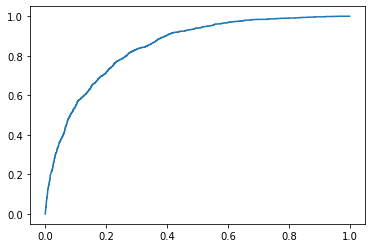

In [10]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

logistic_regression_probabilities = pipe.predict_proba(X_test)
logistic_regression_probabilities = logistic_regression_probabilities[:, 1]
logistic_regression_auc = roc_auc_score(y_test, logistic_regression_probabilities)
print('Logistic: AUROC=%.3f' % (logistic_regression_auc))
logistic_regression_fpr, logistic_regression_tpr, _ = roc_curve(y_test, logistic_regression_probabilities)
pyplot.plot(logistic_regression_fpr, logistic_regression_tpr, label='Logistic')
pyplot.show()

We find an AUC of 0.83. Not bad for a quick exercise without fine tuning.


## Interpretability model
We use [lime](https://github.com/marcotcr/lime) (Local Interpretable Model-Agnostic Explanations) to explain the predictions.
It is a method of determining which feature has the greatest effect on the predicted value,
and is explained in depth in the the [FFL report](https://ff06-2020.fastforwardlabs.com/).
For more information, refer to the [lime documentation](https://lime-ml.readthedocs.io/en/latest/lime.html).

In [11]:
from lime.lime_tabular import LimeTabularExplainer

data[labels.name + ' probability'] = pipe.predict_proba(X)[:, 1]

# List of length number of features, containing names of features in order
# in which they appear in X
feature_names = list(ce.columns_)

# List of indices of columns of X containing categorical features
categorical_features = list(ce.cat_columns_ix_.values())

# List of (index, [cat1, cat2...]) index-strings tuples, where each index
# is that of a categorical column in X, and the list of strings are the
# possible values it can take
categorical_names = {i: ce.classes_[c]
                     for c, i in ce.cat_columns_ix_.items()}
class_names = ['No ' + labels.name, labels.name]
explainer = LimeTabularExplainer(ce.transform(data),
                                 feature_names=feature_names,
                                 class_names=class_names,
                                 categorical_features=categorical_features,
                                 categorical_names=categorical_names)    

## Explaining a Single Prediction

Let's look at how one specfic prediction would be interpreted.
Lime explains the prediction by giving every feature a weight from -1 to 1.
Features with weights closer to -1 have a stronger impact in coming up with a 0 prediction result (will not churn) and vice versa.

In [12]:
data.sample().T  # reminder of the features

id,445230
gender,Male
SeniorCitizen,0
Partner,Yes
Dependents,Yes
tenure,71
PhoneService,Yes
MultipleLines,Yes
InternetService,Fiber optic
OnlineSecurity,Yes
OnlineBackup,Yes


In [13]:
exp = explainer.explain_instance(ce.transform(data.sample())[0],pipe.predict_proba)
for cols in exp.as_list():
    print(cols)

('tenure <= 9.00', 0.3100985011180062)
('InternetService=DSL', -0.15345846577674632)
('Contract=Month-to-month', 0.11959483482161667)
('401.45 < TotalCharges <= 1397.47', -0.07257370972114702)
('StreamingMovies=Yes', 0.06296343951558728)
('MultipleLines=Yes', 0.05213573587458135)
('TechSupport=No', 0.048021281009265504)
('PaperlessBilling=No', -0.04027767314043304)
('OnlineSecurity=No', 0.036871493457633756)
('35.59 < MonthlyCharges <= 70.35', 0.03520587049618618)


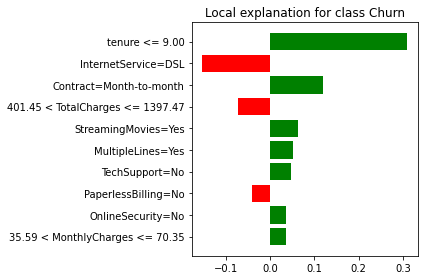

In [14]:
exp.as_pyplot_figure()
plt.tight_layout()

## Saving the model
Now that we've done all this work to build the models, we want to be able to use them later.
The `ExplainedModel` class is a handy wrapper for using the `CategoricalEncoder`, the `Pipeline` object which *is* the churn model, and the Lime Explainer.
Here, we use it to save these trained models for use in later parts of the Project.

In [15]:
from churnexplainer import ExplainedModel

# Create and save the combined Logistic Regression and LIME Explained Model.
explainedmodel = ExplainedModel(
    data=data,
    labels=labels,
    categoricalencoder=ce,
    pipeline=pipe,
    explainer=explainer,
)

explainedmodel.save(model_name='telco_linear')

In [16]:
spark.stop()

## Wrap up
We've now covered all the steps to **building a machine learning model** including interpretability
and saved our work for use in later sections.

In the next part of the series we will explore how to use the **Experiments** feature of CML
for when we want to test lots of combinations of hyperparameters to fine tune our models.


***If this documentation includes code, including but not limited to, code examples, Cloudera makes this available to you under the terms of the Apache License, Version 2.0, including any required notices.  A copy of the Apache License Version 2.0 can be found [here](https://opensource.org/licenses/Apache-2.0).***